In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import simos as sos
import scipy as sc
import qutip as qu

In [2]:
# Spin 1 
A = {'val': 1/2, 'name':'A'} 
# Spin 2
B = {'val': 1/2 , 'name':'B'}

# Construct the system:
SP = sos.System([A,B], method = "qutip")


In [3]:
theta = np.deg2rad(10)
phi  = np.deg2rad(5)
Hdip = sos.dipolar_coupling(SP, "A", "B", sos.yH1, sos.yH1, np.array([2e-10, theta, phi]), mode = "spher", approx = "pseudosecular")
Hz = sos.f2w(200e3)*SP.Az + sos.f2w(201e3)*SP.Bz

In [5]:
store = []
rho0 = SP.Ap[-0.5]*SP.Bp[-0.5]
dt =  1.5e-6
rho = sos.rot((SP.Ax+SP.Bx), np.pi/2, rho0)
U = sos.evol(Hz+Hdip, dt)
for i in range(1000):

    rho = U*rho*U.dag() 
    meas = sos.expect((SP.Ax+1j*SP.Ay + SP.Bx+1j*SP.By), rho)
    store.append(meas)

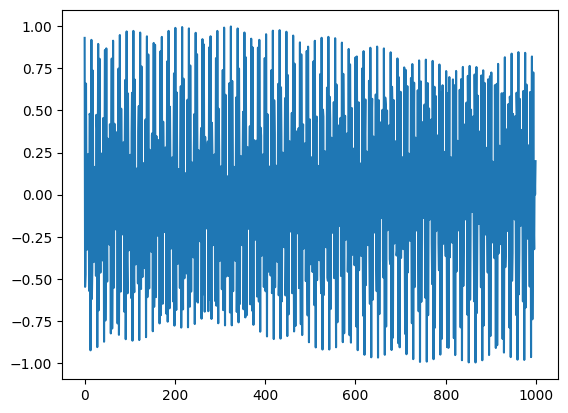

In [6]:
plt.plot(np.real(store))

c:\Users\voelkerl\.conda\envs\spindynamicstaylorsversion\Lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


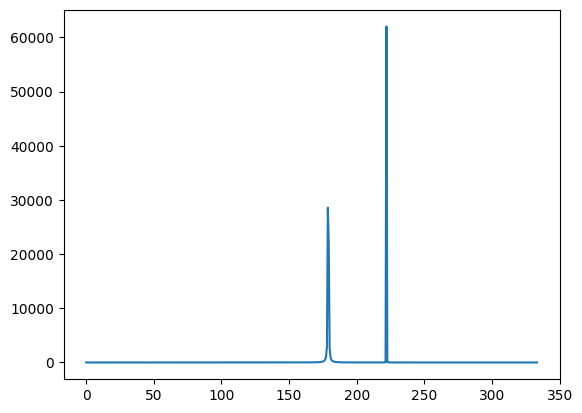

In [7]:
store  = np.array(store)
store = store - np.mean(store)
fft = np.fft.rfft(store)
fax = np.fft.rfftfreq(len(store), dt)
plt.plot(fax*1e-3, np.abs(fft)**2)

Powder

In [8]:
def H_fun(theta):
    Hdip = sos.dipolar_coupling(SP, "A", "B", sos.yH1, sos.yH1, np.array([2e-10, theta, phi]), mode = "spher", approx = "pseudosecular")
    return Hz+Hdip
    

In [9]:
params = sos.StochasticLiouvilleParameters()
params["theta"].values = np.linspace(0, np.pi, 100)
params["theta"].dynamics = {0:1}
params["theta"].weights = np.sin(params["theta"].values)



In [10]:
store = []
rho0 = SP.Ap[-0.5]*SP.Bp[-0.5]
dt =  1.5e-6
rho0 = sos.rot((SP.Ax+SP.Bx), np.pi/2, rho0)

for i in sos.bar(range(500)):
    rho = sos.stochastic_evol(H_fun, params, i*dt, rho0) 

    meas = sos.expect((SP.Ax+1j*SP.Ay + SP.Bx+1j*SP.By), rho)
    store.append(meas)

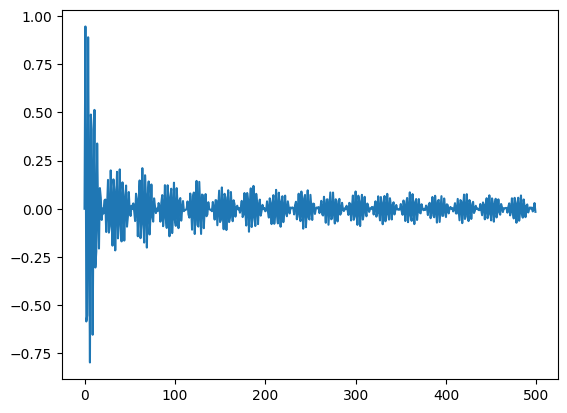

In [11]:
plt.plot(np.real(store))

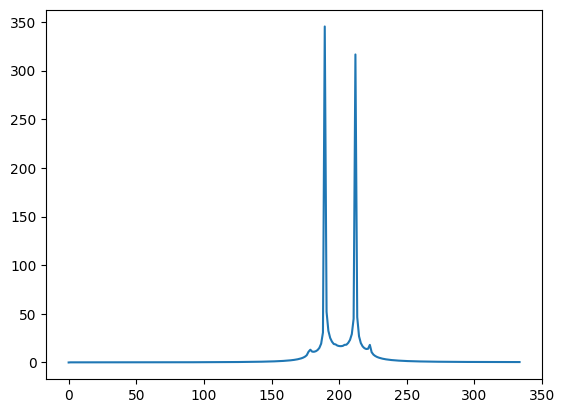

In [12]:
store  = np.array(store)
store = store - np.mean(store)
fft = np.fft.rfft(store)
fax = np.fft.rfftfreq(len(store), dt)
plt.plot(fax*1e-3, np.abs(fft)**2)

MAS Case 

ohne mas 

In [13]:
startvec = sos.spher2cart(np.array([3.5e-10, np.deg2rad(0), np.deg2rad(0)]))[0]

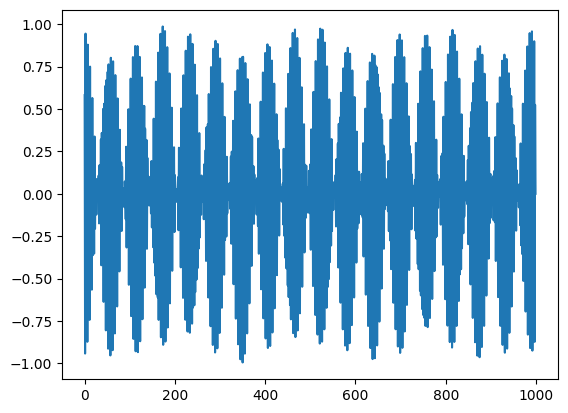

In [57]:

Hdip = sos.dipolar_coupling(SP, "A", "B", sos.yH1, sos.yH1, startvec, mode = "cart", approx = "pseudosecular")
Hz = sos.f2w(200e3)*SP.Az + sos.f2w(201e3)*SP.Bz

store = []
rho0 = SP.Ap[-0.5]*SP.Bp[-0.5]
dt =  2e-6
rho = sos.rot((SP.Ax+SP.Bx), np.pi/2, rho0)
U = sos.evol(Hz+Hdip, dt)
for i in range(1000):

    rho = U*rho*U.dag() 
    meas = sos.expect((SP.Ax+1j*SP.Ay + SP.Bx+1j*SP.By), rho)
    store.append(meas)

plt.plot(np.real(store))

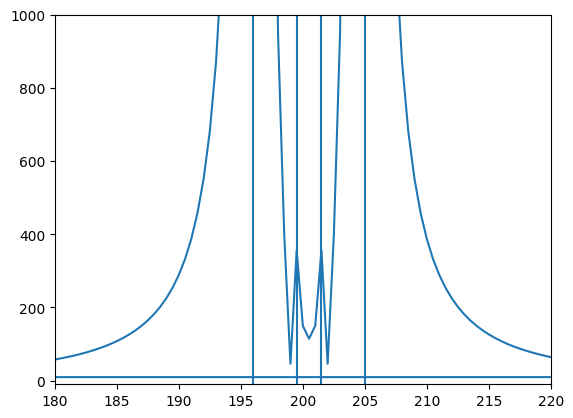

In [67]:
store  = np.array(store)
store = store - np.mean(store)
fft = np.fft.fft(store)
fax = np.fft.fftfreq(len(store), dt)
plt.plot(fax*1e-3, np.abs(fft)**2)
plt.xlim([180,220])
plt.ylim([-10,1e3])
pks,_ = sc.signal.find_peaks(np.abs(fft)**2)
for pi in pks:
    plt.axvline(fax[pi]*1e-3)


In [44]:
paramsMAS = sos.StochasticLiouvilleParameters()
paramsMAS["phi"].values = np.linspace(0, 2*np.pi, 20)
paramsMAS["phi"].dynamics = {1:sos.f2w(500e3)}
paramsMAS["phi"].weights = None

In [45]:
mystartvec = np.transpose(np.array([startvec]))
def H_fun_dummyMAS(phi):
    rotvec = phi*np.array([0,0,1]) #(np.array([1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]))
    R = sc.spatial.transform.Rotation.from_rotvec(rotvec)
    Rmat = R.as_matrix()
    phivec = np.transpose(Rmat@mystartvec.copy())
    #print(phivec)
    Hdip = sos.dipolar_coupling(SP, "A", "B", sos.yH1, sos.yH1, phivec, mode = "cart", approx = "pseudosecular")
    return Hz+Hdip 
def H_fun_MAS(phi):
    rotvec = phi*np.array([1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)])
    R = sc.spatial.transform.Rotation.from_rotvec(rotvec)
    Rmat = R.as_matrix()
    phivec = np.transpose(Rmat@mystartvec.copy())
    #print(phivec)
    Hdip = sos.dipolar_coupling(SP, "A", "B", sos.yH1, sos.yH1, phivec, mode = "cart", approx = "pseudosecular")
    return Hz+Hdip 

In [46]:
startvec

array([0.0e+00, 0.0e+00, 3.5e-10])

In [47]:
for phi in paramsMAS["phi"].values:
    print(H_fun_MAS(phi))
    

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1250977.05371591        0.                0.                0.        ]
 [       0.             5660.00772001     8801.6003736         0.        ]
 [       0.             8801.6003736     11943.19302719        0.        ]
 [       0.                0.                0.         -1268580.25446311]]
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1251913.61736346        0.                0.                0.        ]
 [       0.             4723.44407246     7865.03672605        0.        ]
 [       0.             7865.03672605    11006.62937964        0.        ]
 [       0.                0.                0.         -1267643.69081555]]
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1254427.96610285        0.                0.                0.        ]
 [       0.         

In [48]:
1/500e3

2e-06

In [49]:
store = []
rho0 = SP.Ap[-0.5]*SP.Bp[-0.5]
dt =  2e-6
rho0 = sos.rot((SP.Ax+SP.Bx), np.pi/2, rho0)

for i in sos.bar(range(500)):
    rho = sos.stochastic_evol(H_fun_dummyMAS, paramsMAS, i*dt, rho0) 
    meas = sos.expect((SP.Ax+1j*SP.Ay + SP.Bx+1j*SP.By), rho)
    store.append(meas)

dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims 

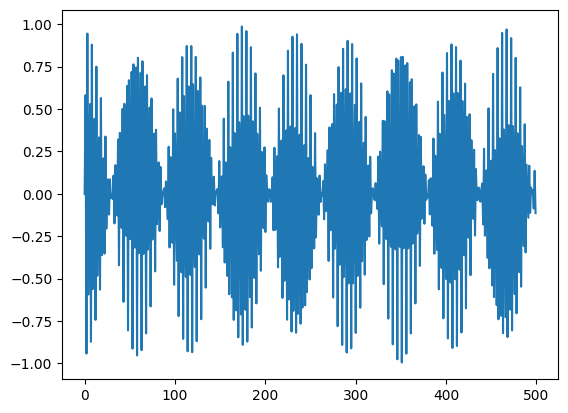

In [50]:
plt.plot(np.real(store))

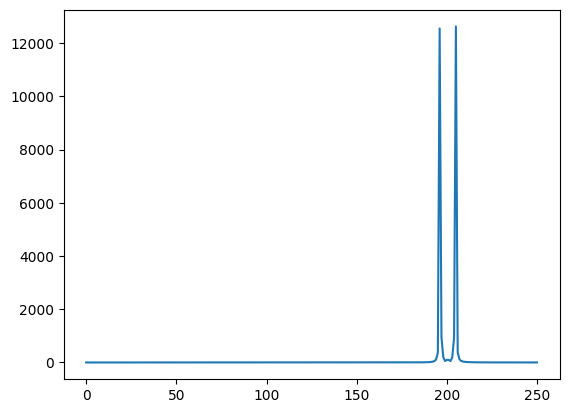

In [51]:

store  = np.array(store)
store = store - np.mean(store)
fft = np.fft.rfft(store)
fax = np.fft.rfftfreq(len(store), dt)
plt.plot(fax*1e-3, np.abs(fft)**2)

In [52]:
store = []
rho0 = SP.Ap[-0.5]*SP.Bp[-0.5]
dt =  2e-6
rho0 = sos.rot((SP.Ax+SP.Bx), np.pi/2, rho0)

for i in sos.bar(range(500)):
    rho = sos.stochastic_evol(H_fun_MAS, paramsMAS, i*dt, rho0) 
    meas = sos.expect((SP.Ax+1j*SP.Ay + SP.Bx+1j*SP.By), rho)
    store.append(meas)

dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims individual_mixers[0] [[20], [20]] (20, 20)
dims one_mixer [[20], [20]] (20, 20)
dims ones[0] [[20], [20]] (20, 20)
dims 

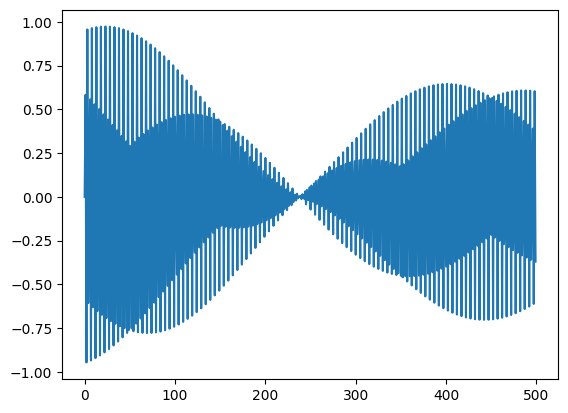

In [53]:
plt.plot(np.real(store))

c:\Users\voelkerl\.conda\envs\spindynamicstaylorsversion\Lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


(array([200], dtype=int64), {})

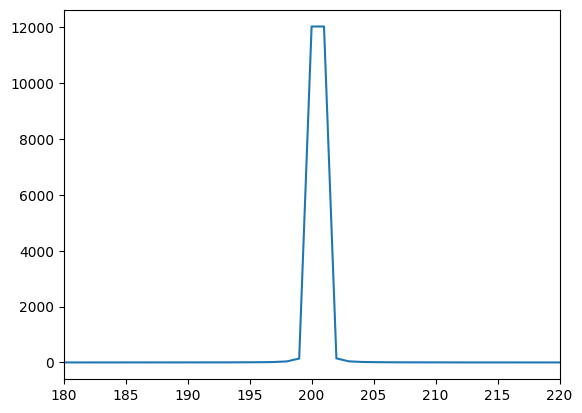

In [56]:

store  = np.array(store)
store = store - np.mean(store)
fft = np.fft.rfft(store)
fax = np.fft.rfftfreq(len(store), dt)
plt.plot(fax*1e-3, np.abs(fft)**2)
plt.xlim([180,220])
sc.signal.find_peaks(np.abs(fft))

Example 3: Rotational Diffusion 

In [4]:
paramsRotDiff = sos.StochasticLiouvilleParameters()
paramsRotDiff["phix"].values = np.linspace(0, 2*np.pi, 10)
paramsRotDiff["phix"].dynamics = {2:sos.f2w(500e3)}
paramsRotDiff["phix"].weights = None

paramsRotDiff["phiy"].values = np.linspace(0, 2*np.pi, 10)
paramsRotDiff["phiy"].dynamics = {2:sos.f2w(500e3)}
paramsRotDiff["phiy"].weights = None

paramsRotDiff["phiz"].values = np.linspace(0, 2*np.pi, 10)
paramsRotDiff["phiz"].dynamics = {2:sos.f2w(500e3)}
paramsRotDiff["phiz"].weights = None

In [5]:
startvec = sos.spher2cart(np.array([3.5e-10, np.deg2rad(0), np.deg2rad(0)]))[0]
mystartvec = np.transpose(np.array([startvec]))
Hz = sos.f2w(200e3)*SP.Az + sos.f2w(201e3)*SP.Bz
mystartvec

def H_fun_RotDiff(phix, phiy, phiz):
    rotvecx =  phix*np.array([1, 0, 0])
    Rxmat = sc.spatial.transform.Rotation.from_rotvec(rotvecx).as_matrix()
    rotvecy =  phiy*np.array([0, 1, 0])
    Rymat = sc.spatial.transform.Rotation.from_rotvec(rotvecy).as_matrix()
    rotvecz =  phiz*np.array([0, 0, 1])
    Rzmat = sc.spatial.transform.Rotation.from_rotvec(rotvecz).as_matrix()

    phivec = Rxmat@mystartvec.copy()
    phivec = Rymat@phivec
    phivec = np.transpose(Rzmat@phivec)

    Hdip = sos.dipolar_coupling(SP, "A", "B", sos.yH1, sos.yH1, phivec, mode = "cart", approx = "pseudosecular")
    return Hz+Hdip 

In [6]:
store = []
rho0 = SP.Ap[-0.5]*SP.Bp[-0.5]
dt =  2e-6
rho0 = sos.rot((SP.Ax+SP.Bx), np.pi/2, rho0)

for i in sos.bar(range(500)):
    rho = sos.stochastic_evol(H_fun_RotDiff, paramsRotDiff, i*dt, rho0) 
    meas = sos.expect((SP.Ax+1j*SP.Ay + SP.Bx+1j*SP.By), rho)
    store.append(meas)

dims ones[0] [[10], [10]] (10, 10)
dims individual_mixers[0] [[10], [10]] (10, 10)
dims one_mixer [[1000], [1000]] (1000, 1000)
dims ones[0] [[10], [10]] (10, 10)
dims individual_mixers[0] [[10], [10]] (10, 10)
dims one_mixer [[1000], [1000]] (1000, 1000)
dims ones[0] [[10], [10]] (10, 10)
dims individual_mixers[0] [[10], [10]] (10, 10)
dims one_mixer [[1000], [1000]] (1000, 1000)
dims ones[0] [[10], [10]] (10, 10)
dims individual_mixers[0] [[10], [10]] (10, 10)
dims one_mixer [[1000], [1000]] (1000, 1000)
dims ones[0] [[10], [10]] (10, 10)
dims individual_mixers[0] [[10], [10]] (10, 10)
dims one_mixer [[1000], [1000]] (1000, 1000)
dims ones[0] [[10], [10]] (10, 10)
dims individual_mixers[0] [[10], [10]] (10, 10)
dims one_mixer [[1000], [1000]] (1000, 1000)
dims ones[0] [[10], [10]] (10, 10)
dims individual_mixers[0] [[10], [10]] (10, 10)
dims one_mixer [[1000], [1000]] (1000, 1000)
dims ones[0] [[10], [10]] (10, 10)
dims individual_mixers[0] [[10], [10]] (10, 10)
dims one_mixer [[1000

KeyboardInterrupt: 